In [1]:
import numpy as np
import pandas as pd
np.random.seed(99)


In [2]:
import random
import math

class QueueModel:
    def __init__(self, arrival_rate, serve_time, num_servers, max_queue_length, simulation_time):
        self.arrival_rate = arrival_rate / 60
        self.serve_time = serve_time / 60
        self.num_servers = num_servers
        self.max_queue_length = max_queue_length
        self.simulation_time = simulation_time
        self.reset_model()

    def reset_model(self):
        self.clock_time = 0
        self.num_busy = 0
        self.num_in_q = 0
        self.time_of_last_event = 0

        self.num_served = 0
        self.num_lost = 0
        self.max_num_in_q = 0
        self.max_wait_time = 0
        self.total_time_in_q = 0
        self.total_time_busy = 0
        self.total_serve_times = [0] * (self.num_servers + 1)

        self.event_scheduled = [False] * (self.num_servers + 1)
        self.time_of_next_event = [float('inf')] * (self.num_servers + 1)
        self.time_of_arrival = []

        self.event_scheduled[0] = True
        self.time_of_next_event[0] = self.random_time(1 / self.arrival_rate)

    def random_time(self, rate):
        return -math.log(1.0 - random.random()) / rate
    
    def find_next_event(self):
        min_time = float('inf')
        finished_server = -1
        next_event_type = None

        for i, (scheduled, event_time) in enumerate(zip(self.event_scheduled, self.time_of_next_event)):
            if scheduled and event_time < min_time:
                min_time = event_time
                finished_server = i
                next_event_type = 1 if i == 0 else 2

        return next_event_type, finished_server, min_time

    def update_statistics(self):
        time_since_last_event = self.clock_time - self.time_of_last_event
        self.total_time_in_q += self.num_in_q * time_since_last_event
        self.total_time_busy += self.num_busy * time_since_last_event
        self.time_of_last_event = self.clock_time

    def arrival(self):
        if self.num_busy < self.num_servers:
            self.num_busy += 1
            self.event_scheduled[self.num_busy] = True
            self.time_of_next_event[self.num_busy] = self.clock_time + self.random_time(1 / self.serve_time)
        elif self.num_in_q < self.max_queue_length:
            self.num_in_q += 1
            self.time_of_arrival.append(self.clock_time)
            if self.num_in_q > self.max_num_in_q:
                self.max_num_in_q = self.num_in_q
        else:
            self.num_lost += 1
        self.time_of_next_event[0] = self.clock_time + self.random_time(1 / self.arrival_rate)

    def departure(self, finished_server):
        if self.num_in_q > 0:
            self.num_in_q -= 1
            wait_time = self.clock_time - self.time_of_arrival.pop(0)
            self.total_time_in_q += wait_time
            self.max_wait_time = max(self.max_wait_time, wait_time)
            self.time_of_next_event[finished_server] = self.clock_time + self.random_time(1 / self.serve_time)
        else:
            self.num_busy -= 1
            self.event_scheduled[finished_server] = False
        self.total_serve_times[finished_server] += self.clock_time - self.time_of_next_event[finished_server]
        self.num_served += 1
        self.time_of_next_event[finished_server] = self.clock_time + self.random_time(1 / self.serve_time)

    def reportWithX(self, x1, x2, x3):
        avg_time_in_q = self.total_time_in_q / self.num_served if self.num_served > 0 else 0
        avg_num_in_q = self.total_time_in_q / self.num_served
        utilization = [(self.total_time_busy / self.simulation_time) * 100 for i in range(1, self.num_servers + 1)]
        percent_unserved = self.num_lost / (self.num_lost + self.num_served) * 100 if (self.num_lost + self.num_served) > 0 else 0

        return (
            x1,
            x2,
            x3,
            self.clock_time,
            avg_time_in_q,
            self.max_wait_time,
            avg_num_in_q,
            self.max_num_in_q,
            int(utilization[0] / self.num_servers) if int(utilization[0] / self.num_servers) < 100 else 100,
            self.num_served,
            self.num_lost,
            percent_unserved
        )
    
    def report(self):
        avg_time_in_q = self.total_time_in_q / self.num_served if self.num_served > 0 else 0
        avg_num_in_q = self.total_time_in_q / self.num_served
        utilization = [(self.total_time_busy / self.simulation_time) * 100 for i in range(1, self.num_servers + 1)]
        percent_unserved = self.num_lost / (self.num_lost + self.num_served) * 100 if (self.num_lost + self.num_served) > 0 else 0

        return (
            self.clock_time,
            avg_time_in_q,
            self.max_wait_time,
            avg_num_in_q,
            self.max_num_in_q,
            int(utilization[0] / self.num_servers) if int(utilization[0] / self.num_servers) < 100 else 100,
            self.num_served,
            self.num_lost,
            percent_unserved
        )

    def run_model(self):
        self.reset_model()
        while True:
            next_event_type, finished_server, next_event_time = self.find_next_event()
            if self.clock_time >= self.simulation_time and all(not scheduled for scheduled in self.event_scheduled[1:]):
                break
            self.clock_time = next_event_time
            self.update_statistics()
            if next_event_type == 1:
                if self.clock_time < self.simulation_time:
                    self.arrival()
                else:
                    self.time_of_next_event[0] = float('inf')
            elif next_event_type == 2:
                self.departure(finished_server)

        while self.num_in_q > 0:
            next_event_type, finished_server, next_event_time = self.find_next_event()
            self.clock_time = next_event_time
            self.update_statistics()
            if next_event_type == 1:
                if self.clock_time < self.simulation_time:
                    self.arrival()
                else:
                    self.time_of_next_event[0] = float('inf')
            elif next_event_type == 2:
                self.departure(finished_server)


In [3]:
results = []
model = QueueModel(arrival_rate=np.random.uniform(1,7), 
                       serve_time=np.random.uniform(1,10), 
                       num_servers=int(np.random.uniform(1,12)), 
                       max_queue_length=20, 
                       simulation_time=500)
for _ in range(100):
    model.run_model()
    results.append(model.report())

In [4]:
df = pd.DataFrame(results)

print(" 0: Время выхода последней заявки из системы\n",
    "1: Среднее время ожидания в очереди\n",
    "2: Максимальное время ожидания в очереди\n",
    "3: Среднее количество заявок в очереди\n",
    "4: Максимальное количество заявок в очереди\n",
    "5: Процент занятости каждого прибора обслуживания\n",
    "6: Количество обслуженных заявок\n",
    "7: Количество необслуженных заявок\n",
    "8: Процент необслуженных заявок\n")

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 10000)
print(df)

 0: Время выхода последней заявки из системы
 1: Среднее время ожидания в очереди
 2: Максимальное время ожидания в очереди
 3: Среднее количество заявок в очереди
 4: Максимальное количество заявок в очереди
 5: Процент занятости каждого прибора обслуживания
 6: Количество обслуженных заявок
 7: Количество необслуженных заявок
 8: Процент необслуженных заявок

             0         1         2         3   4   5     6    7          8
0   502.674607  2.003318  3.129324  2.003318  20  98  5378  424   7.307825
1   501.265708  2.251021  2.946704  2.251021  20  99  5497  529   8.778626
2   501.317782  2.216492  3.194849  2.216492  20  99  5364  645  10.733899
3   501.342746  2.176547  3.148381  2.176547  20  99  5364  493   8.417278
4   501.820232  2.220310  3.357113  2.220310  20  99  5459  555   9.228467
..         ...       ...       ...       ...  ..  ..   ...  ...        ...
95  501.536621  2.082951  3.250259  2.082951  20  99  5479  477   8.008731
96  502.140336  2.028457  2.856553  

In [5]:
correlation_matrix = df.corr()
correlation_matrix_rounded = correlation_matrix.round(2)
n_rows, n_cols = correlation_matrix_rounded.shape

for i in range(n_rows):
    for j in range(i + 1, n_cols):
        correlation_matrix_rounded.iloc[i, j] = np.nan

for i in range(n_rows):
    str = ""
    for j in range(0, i + 1):
        str += f"{(correlation_matrix_rounded.iloc[i, j])}"+ '\t'
    print(str)

1.0	
0.15	1.0	
0.2	0.24	1.0	
0.15	1.0	0.24	1.0	
nan	nan	nan	nan	nan	
0.19	0.11	0.01	0.11	nan	1.0	
-0.05	-0.38	-0.19	-0.38	nan	0.02	1.0	
0.17	0.83	0.36	0.83	nan	0.1	-0.41	1.0	
0.17	0.83	0.37	0.83	nan	0.09	-0.47	1.0	1.0	


In [6]:
thresholds = [0.9, 0.8, 0.7]
correlated_groups = {threshold: [] for threshold in thresholds}

for i in range(n_rows):
    for j in range(i):
        value = correlation_matrix_rounded.iloc[i, j]
        if not np.isnan(value):
            for threshold in thresholds:
                if abs(value) > threshold:
                    correlated_groups[threshold].append((i+1, j+1, value))
                    break

correlated_groups

{0.9: [(4, 2, 1.0), (9, 8, 1.0)],
 0.8: [(8, 2, 0.83), (8, 4, 0.83), (9, 2, 0.83), (9, 4, 0.83)],
 0.7: []}

In [7]:
representatives = {}
for threshold, groups in correlated_groups.items():
    rep_counts = {}
    for group in groups:
        for index in group[:2]:
            rep_counts[index] = rep_counts.get(index, 0) + 1
    if rep_counts:
        max_count = max(rep_counts.values())
        for index, count in rep_counts.items():
            if count == max_count:
                representatives[threshold] = index
                break
    else:
        representatives[threshold] = 9
representatives

{0.9: 4, 0.8: 8, 0.7: 9}

In [8]:
top_two_representatives = list(representatives.values())[:2]
top_two_representatives

[4, 8]

In [9]:
resultsSecond = []
for _ in range(30):
    x1 = np.random.uniform(1, 7)
    x2 = np.random.uniform(1, 10)
    x3 = int(np.random.uniform(1, 12))
    model = QueueModel(arrival_rate=x1, 
                       serve_time=x2, 
                       num_servers=x3, 
                       max_queue_length=20, 
                       simulation_time=500)
    model.run_model()
    resultsSecond.append(model.reportWithX(x1, x2, x3))
resultsSecond

[(1.1886783257577889,
  8.27244967028363,
  7,
  500.87955342935834,
  1.2657234341455534,
  1.3764533506539465,
  1.2657234341455534,
  20,
  100,
  14674,
  10317,
  41.282861830258895),
 (2.785734992223664,
  1.4202614845625794,
  11,
  500.00572452231035,
  0.04962603730812093,
  0.5205269507291632,
  0.04962603730812093,
  17,
  94,
  10767,
  0,
  0.0),
 (1.0409543982619311,
  7.928137253709458,
  9,
  501.28110898374933,
  1.710317010671708,
  1.7105180065788659,
  1.710317010671708,
  20,
  100,
  11308,
  17276,
  60.43940666106913),
 (3.264633618009791,
  5.447327070168783,
  11,
  501.1053424829714,
  3.370946451438197,
  3.168203764945247,
  3.370946451438197,
  20,
  99,
  5471,
  3544,
  39.31225734886301),
 (3.372724266074922,
  9.76560667146064,
  6,
  502.04347362139475,
  3.007603751421838,
  2.915431657444117,
  3.007603751421838,
  20,
  100,
  6016,
  3029,
  33.4881149806523),
 (1.5616785597865155,
  8.31977571503916,
  3,
  500.9825449545941,
  1.7571058922339349

In [10]:
dfSecond = pd.DataFrame(resultsSecond)

print(" 0: Время выхода последней заявки из системы\n",
    "1: Среднее время ожидания в очереди\n",
    "2: Максимальное время ожидания в очереди\n",
    "3: Среднее количество заявок в очереди\n",
    "4: Максимальное количество заявок в очереди\n",
    "5: Процент занятости каждого прибора обслуживания\n",
    "6: Количество обслуженных заявок\n",
    "7: Количество необслуженных заявок\n",
    "8: Процент необслуженных заявок\n")

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 10000)
print(dfSecond)

 0: Время выхода последней заявки из системы
 1: Среднее время ожидания в очереди
 2: Максимальное время ожидания в очереди
 3: Среднее количество заявок в очереди
 4: Максимальное количество заявок в очереди
 5: Процент занятости каждого прибора обслуживания
 6: Количество обслуженных заявок
 7: Количество необслуженных заявок
 8: Процент необслуженных заявок

          0         1   2           3         4         5         6   7    8   \
0   1.188678  8.272450   7  500.879553  1.265723  1.376453  1.265723  20  100   
1   2.785735  1.420261  11  500.005725  0.049626  0.520527  0.049626  17   94   
2   1.040954  7.928137   9  501.281109  1.710317  1.710518  1.710317  20  100   
3   3.264634  5.447327  11  501.105342  3.370946  3.168204  3.370946  20   99   
4   3.372724  9.765607   6  502.043474  3.007604  2.915432  3.007604  20  100   
5   1.561679  8.319776   3  500.982545  1.757106  2.002539  1.757106  20  100   
6   4.326075  3.630422   9  500.016947  0.611150  1.680151  0.611150 

In [11]:
selected_columns = [0, 1, 2, 2+top_two_representatives[0], 2+top_two_representatives[1]]
dfSecond_filtered = dfSecond.iloc[:, selected_columns]
dfSecond_filtered


,0,1,2,6,10
0,1.188678,8.272450,7,1.265723,10317
1,2.785735,1.420261,11,0.049626,0
2,1.040954,7.928137,9,1.710317,17276
3,3.264634,5.447327,11,3.370946,3544
4,3.372724,9.765607,6,3.007604,3029
5,1.561679,8.319776,3,1.757106,8503
6,4.326075,3.630422,9,0.611150,28
7,5.968255,2.994196,8,0.107261,0
8,1.571090,4.704969,2,2.126994,10353
9,1.864066,2.909766,6,1.746439,5600


In [12]:
import statsmodels.api as sm

X = dfSecond_filtered[[0, 1, 2]]
y1 = dfSecond_filtered[2+top_two_representatives[0]]
X_with_constant = sm.add_constant(X)
model_y1 = sm.OLS(y1, X_with_constant).fit()
y2 = dfSecond_filtered[2+top_two_representatives[0]]
model_y2 = sm.OLS(y2, X_with_constant).fit()

y1_results = model_y1.summary()
y2_results = model_y2.summary()

y1_r_squared = model_y1.rsquared
y1_results_R = np.sqrt(y1_r_squared)
y1_adj_r_squared = model_y1.rsquared_adj
y1_std_err = model_y1.bse

print("Линейная регрессия\n-----------------------------------------------------")
print(f"Множественный R: {y1_r_squared:.2f}")
print(f"R-квадрат: {y1_results_R:.2f}")
print(f"Нормированный R-квадрат: {y1_adj_r_squared:.2f}")
print(f"Стандартная ошибка: {y1_std_err[0]:.2f}, {y1_std_err[1]:.2f}, {y1_std_err[2]:.2f}")

print("")

Линейная регрессия
-----------------------------------------------------
Множественный R: 0.64
R-квадрат: 0.80
Нормированный R-квадрат: 0.60
Стандартная ошибка: 0.13, 0.09, 0.06



In [13]:
dfSecond_filtered_copy = dfSecond_filtered.copy()
dfSecond_filtered_copy['x1'] = dfSecond_filtered_copy.iloc[:, 0]
dfSecond_filtered_copy['x2'] = dfSecond_filtered_copy.iloc[:, 1]
dfSecond_filtered_copy['x3'] = dfSecond_filtered_copy.iloc[:, 2]
dfSecond_filtered_copy['x1_squared'] = dfSecond_filtered_copy.iloc[:, 0] ** 2
dfSecond_filtered_copy['x2_squared'] = dfSecond_filtered_copy.iloc[:, 1] ** 2
dfSecond_filtered_copy['x3_squared'] = dfSecond_filtered_copy.iloc[:, 2] ** 2
dfSecond_filtered_copy['x1_x2'] = dfSecond_filtered_copy.iloc[:, 0] * dfSecond_filtered_copy.iloc[:, 1]
dfSecond_filtered_copy['x1_x3'] = dfSecond_filtered_copy.iloc[:, 0] * dfSecond_filtered_copy.iloc[:, 2]
dfSecond_filtered_copy['x2_x3'] = dfSecond_filtered_copy.iloc[:, 1] * dfSecond_filtered_copy.iloc[:, 2]
dfSecond_filtered_copy['y1'] = dfSecond_filtered_copy.iloc[:, 2+top_two_representatives[0]]
dfSecond_filtered_copy['y2'] = dfSecond_filtered_copy.iloc[:, 2+top_two_representatives[1]]

dfSecond_filtered_copy

,0,1,2,6,10,x1,x2,x3,x1_squared,x2_squared,x3_squared,x1_x2,x1_x3,x2_x3,y1,y2
0,1.188678,8.272450,7,1.265723,10317,1.188678,8.272450,7,1.412956,68.433424,49,9.833282,8.320748,57.907148,8.272450,49
1,2.785735,1.420261,11,0.049626,0,2.785735,1.420261,11,7.760319,2.017143,121,3.956472,30.643085,15.622876,1.420261,121
2,1.040954,7.928137,9,1.710317,17276,1.040954,7.928137,9,1.083586,62.855360,81,8.252829,9.368590,71.353235,7.928137,81
3,3.264634,5.447327,11,3.370946,3544,3.264634,5.447327,11,10.657833,29.673372,121,17.783527,35.910970,59.920598,5.447327,121
4,3.372724,9.765607,6,3.007604,3029,3.372724,9.765607,6,11.375269,95.367074,36,32.936699,20.236346,58.593640,9.765607,36
5,1.561679,8.319776,3,1.757106,8503,1.561679,8.319776,3,2.438840,69.218668,9,12.992815,4.685036,24.959327,8.319776,9
6,4.326075,3.630422,9,0.611150,28,4.326075,3.630422,9,18.714922,13.179964,81,15.705477,38.934672,32.673798,3.630422,81
7,5.968255,2.994196,8,0.107261,0,5.968255,2.994196,8,35.620072,8.965212,64,17.870128,47.746043,23.953571,2.994196,64
8,1.571090,4.704969,2,2.126994,10353,1.571090,4.704969,2,2.468323,22.136735,4,7.391929,3.142179,9.409938,4.704969,4
9,1.864066,2.909766,6,1.746439,5600,1.864066,2.909766,6,3.474742,8.466736,36,5.423995,11.184396,17.458593,2.909766,36


In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
y1_quad = dfSecond_filtered_copy['y1']
model_y1_quad = LinearRegression().fit(X_poly, y1)

y1_r_squared2 = model_y1_quad.score(X_poly, y1)
n = len(y1)
p = X_poly.shape[1]
y1_adj_r_squared2 = 1 - (1 - y1_r_squared2) * (n - 1) / (n - p - 1)

y1_predictions = model_y1_quad.predict(X_poly)
mse = mean_squared_error(y1, y1_predictions)
se = np.sqrt(mse / (n - p - 1))

print("Квадратичная регрессия\n-----------------------------------------------------")
print(f"Множественный R: {np.sqrt(y1_r_squared2):.2f}")
print(f"R-квадрат: {y1_r_squared2:.2f}")
print(f"Нормированный R-квадрат: {y1_adj_r_squared2:.2f}")
print(f"Стандартная ошибка: {se:.2f}")

Квадратичная регрессия
-----------------------------------------------------
Множественный R: 0.94
R-квадрат: 0.89
Нормированный R-квадрат: 0.84
Стандартная ошибка: 0.14


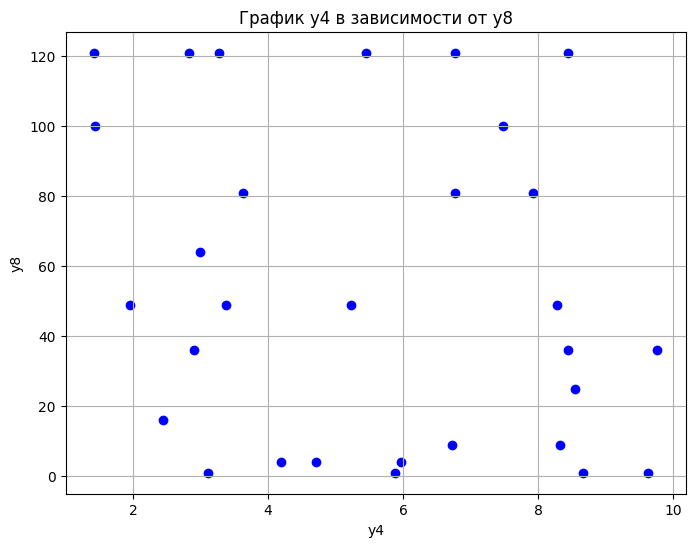

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(dfSecond_filtered_copy['y1'], dfSecond_filtered_copy['y2'], color='blue')
plt.title(f"График y{top_two_representatives[0]} в зависимости от y{top_two_representatives[1]}")
plt.xlabel(f"y{top_two_representatives[0]}")
plt.ylabel(f"y{top_two_representatives[1]}")
plt.grid(True)
plt.show()